In [2]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
import time
from os.path import join, getmtime
import glob
import json
import tensorflow as tf
print(tf.__version__)
import sys
from IPython import display
import requests
import sqlite3
#dont keep api key in github!!!
api_file = join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

2.1.0


In [3]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes')
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']]

## Get 500 last matches to get approximate hero ratios
(likely isn't needed due to the way bulk data is collected)

Need to be careful here so that test dataset doesn't have crossover with training data. My strategy to eliminate overlap was to start collecting match data for the training set for matches after the oldest match in the test set. To get around the 500 match retrieval limit I save 500 at a time to a .csv with a filename that has the start and end match_id. This means I can get 500, wait a bit, then get 500 more that are guarenteed to not have overlap. 

How long do I have to wait to get 500 more?? Unclear and was unable to find documentation. Thanks Valve.

In [ ]:
#get matches data from dota2 API and put IDs into a dataframe
num_requested = 1000
skill = 3
match_list = []

#put a start match_id if I'm trying to get more matches after getting 500
#if trying to load starting from a match_id previously obtained and saved
#use arg: start_at_match_id = old_match_list[-1]-1
matches = api.call('IDOTA2Match_' + dota2_id +'.GetMatchHistory',
                                            hero_id = 121,
                                            game_mode = 1,
                                            skill = skill,
                                            min_players = 10,
                                            matches_requested = 100)

#@TODO: check if lobby_type is public/ranked matching (0 or 7) before appending
[match_list.append(match['match_id']) for match in matches['result']['matches']]

current_num = 100

while current_num <= num_requested:
    
    #check that match request returned any matches before trying to get more
    if len(match_list)==0:
        print('No matches returned\nWait a bit and retry\n\n    GabeN Bless')
    
    #sleep so we don't overload the servers
    time.sleep(1)
                
    current_num += 100
    matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',
                                            start_at_match_id = match_list[-1]-1,
                                            game_mode = 1,
                                            skill = skill,
                                            min_players = 10,
                                            matches_requested = 100)

    #@TODO: check if lobby_type is public/ranked matching (0 or 7) before appending
    [match_list.append(match['match_id']) for match in matches['result']['matches']]

    
dota2_test_df = pd.DataFrame()
dota2_test_df['match_id'] = match_list

In [ ]:
#get match details from match_ids obtained
#add radiant_win column
#add heroes split between dire and radiant

radiant_win_column = []
radiant_hero_column = []
dire_hero_column = []
match_details = []

for match_id in dota2_test_df['match_id']:
    time.sleep(1)
    match_details.append(api.call('IDOTA2Match_' + dota2_id+'.GetMatchDetails',
                                  match_id = str(match_id)))
    radiant_win_column.append(match_details[-1]['result']['radiant_win'])
    
    radiant_hero_row = []
    dire_hero_row = []
    for player in match_details[-1]['result']['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            radiant_hero_row.append(player['hero_id'])
        else:
            dire_hero_row.append(player['hero_id'])
    
    radiant_hero_column.append(radiant_hero_row)
    dire_hero_column.append(dire_hero_row)

In [ ]:
#Add radiant_win column to Dataframe
dota2_test_df['radiant_win'] = 1*np.array(radiant_win_column)

#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(radiant_hero_column)[0])):
    dota2_test_df['radiant_heroes'+str(i)] = np.array(radiant_hero_column)[:,i]
    dota2_test_df['dire_heroes'+str(i)] = np.array(dire_hero_column)[:,i]

In [ ]:
#save data to csv file so that we have it on disk
dota2_test_df.to_csv(os.path.join('dota2_test_data',
                                        str(dota2_test_df['match_id'][0])+
                                        '-'+
                                        str(dota2_test_df['match_id'][499])+'.csv'))

## Load test data that is newest for match_id checking
(to prevent duplicates) This isn't generally necessary because matches happen so fast.

In [ ]:
#Run this if the test data is needed to allow for proper test_data collection
#load newest file so that last_match_id is accurate? Unclear if this is the best strategy... 
#maybe should look at loading all then looking at match_id
dota2_data_files = glob.glob(os.path.join('dota2_test_data','*.csv'))
dota2_data_files.sort(key=os.path.getmtime)

dota2_test_df_from_file = pd.read_csv(dota2_data_files[0], usecols=range(1,13))
dota2_test_df_from_file.style

#purge 0 values from hero_id
dota2_test_df_from_file = dota2_test_df_from_file[dota2_test_df_from_file.radiant_heroes0 != 0]

#make old_match_list for easy checking of match_id
old_match_list = list(dota2_test_df_from_file['match_id'])

# Get 500 matches of each hero id (and trim duplicates)

In [ ]:
hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes',itemizedonly = True)
hero_list=pd.DataFrame(hero_list['result']['heroes'])

## Get match_id of all the matches
this uses GetMatchHistory which is a bit limits match getting to 500 per hero (about 2e4) and sometimes stops returning matches

In [ ]:
#get matches data from dota2 API and put IDs into a dataframe
num_matches_to_request = 500

#skill level of matches to request from 1-3 meaning low-high skill
# 0 will just collect all skills
skill = 3
match_list = []
#flag to allow for fetching older matches to avoid data overlap
most_current_matches = True

#Loop through all hero_id values
#use vocabulary generated by an api call above to get all hero id's
for i in hero_list['id']:
    
    #Get first match for each hero out of loop so that we can pull more than 100 games per hero
    #by utilizing start_at_match_id option
    if most_current_matches==True:
        matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',hero_id = i,
                                                                   game_mode = 1,
                                                                   skill = skill,
                                                                   min_players = 10,
                                                                   matches_requested = 100)
    else:
        files=glob.glob(os.path.join('Dota_data','skill_level='+str(skill),'*.csv'))
        files.sort(key=os.path.getmtime)
        start_match = pd.read_csv(files[-1], usecols=[1])['match_id'].min()-1
        print(start_match)
        matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',hero_id=i,
                                                            start_at_match_id=start_match,
                                                            game_mode=1,
                                                            skill=skill,
                                                            min_players=10,
                                                            matches_requested=100)
    #Append matches to matchlist
    #if lobby_type is public/ranked matching (0 or 7)
    for match in matches['result']['matches']:
        lobby_type=match['lobby_type']
        if lobby_type==0 or lobby_type==7 or lobby_type==5 or lobby_type==2:
            match_list.append(match['match_id'])
            
    current_num = 1

    if len(match_list)==0:
        print('No matches returned\nWait a bit and retry\n\n    GabeN Bless')
        break
    
    while current_num <= num_matches_to_request:
        #sleep so we don't overload the servers
        time.sleep(1)

        current_num += 100
        matches = api.call('IDOTA2Match_' + dota2_id+'.GetMatchHistory',hero_id = i,
                                                        start_at_match_id = match_list[-1]-1,
                                                        game_mode = 1,
                                                        skill = skill,
                                                        min_players = 10,
                                                        matches_requested = 100)
        
        #Append matches to matchlist
        #if lobby_type is public/ranked matching (0 or 7)
        for match in matches['result']['matches']:
            lobby_type=match['lobby_type']
            if lobby_type==0 or lobby_type==7 or lobby_type==5 or lobby_type==2:
                match_list.append(match['match_id'])


## Purge duplicates and add to dataframe

In [ ]:
#Make dataframe of match_id values using dict.fromkeys(list) to remove duplicates
dota2_df = pd.DataFrame()
dota2_df['match_id'] = list(dict.fromkeys(match_list))

dota2_df.describe()

## Save match id list

In [ ]:
dota2_df.to_csv(os.path.join('Dota_data',
                                      'skill_level='+str(skill),
                                      'saved'+time.strftime('%Y-%m-%d')+'.csv'))

# Get match details for matches
this is the best way to do it even though it needs many calls to get the data. GetMatchHistoryBySequenceNum seems nice but there are no filters so the usable matches are ~1/500.

## Load files of match_ids

In [4]:
dota_df = None

files=glob.glob(join('Dota_data','match_ids','skill_level=*','*.csv'))
files.sort(key=getmtime)
#print(files)
for filename in files[:]:
    print(filename)
    if type(dota_df)==None:
        dota_df = pd.read_csv(filename, usecols=[1])
        dota_df['skill_level'] = np.ones(len(dota_df['match_id']))*int(filename[-21])
    else:
        dota_df_new = pd.read_csv(filename, usecols=[1])
        dota_df_new['skill_level'] = np.ones(len(dota_df_new['match_id']))*int(filename[-21])
        dota_df = pd.concat([dota_df, dota_df_new],
                                                    ignore_index=True)

dota_df.describe()

Dota_data/match_ids/skill_level=3/saved2019-05-24.csv
Dota_data/match_ids/skill_level=3/saved2019-05-23.csv
Dota_data/match_ids/skill_level=3/saved2019-05-22.csv
Dota_data/match_ids/skill_level=3/saved2019-05-21.csv
Dota_data/match_ids/skill_level=3/saved2019-05-13.csv
Dota_data/match_ids/skill_level=3/saved2019-05-12.csv
Dota_data/match_ids/skill_level=3/saved2019-05-08.csv
Dota_data/match_ids/skill_level=3/saved2019-05-06.csv
Dota_data/match_ids/skill_level=2/saved2019-05-24.csv
Dota_data/match_ids/skill_level=2/saved2019-05-23.csv
Dota_data/match_ids/skill_level=2/saved2019-05-22.csv
Dota_data/match_ids/skill_level=2/saved2019-05-20.csv
Dota_data/match_ids/skill_level=2/saved2019-05-13.csv
Dota_data/match_ids/skill_level=2/saved2019-05-12.csv
Dota_data/match_ids/skill_level=2/saved2019-05-08.csv
Dota_data/match_ids/skill_level=2/saved2019-05-06.csv
Dota_data/match_ids/skill_level=1/saved2019-05-24.csv
Dota_data/match_ids/skill_level=1/saved2019-05-23.csv
Dota_data/match_ids/skill_le

,match_id,skill_level
count,2.878220e+05,287822.000000
mean,4.757200e+09,1.972292
std,1.988449e+07,0.821628
min,4.725403e+09,1.000000
25%,4.733830e+09,1.000000
50%,4.749397e+09,2.000000
75%,4.775588e+09,3.000000
max,4.781085e+09,3.000000


## Get the details and store in dict
store in memory for later export

In [20]:
#initialize data columns if you're starting a match_detail getting batch
#if trying to finish one that broke unexpectedly then don't run!
feature_name_list=['match_id','match_seq_num','start_time','duration','game_mode','cluster',
                   'lobby_type','skill_level','radiant_win','radiant_kills','dire_kills',
                   'radiant_gold','dire_gold','radiant_xp','dire_xp',
                   'radiant_tower_status','dire_tower_status',
                   'radiant_barrack_status','dire_barrack_status',
                   'first_blood_time']
match_detail_dict={}
for feature in feature_name_list:
    match_detail_dict[feature]=[]

for i in range(5):
    match_detail_dict['radiant_hero'+str(i)]=[]
    match_detail_dict['dire_hero'+str(i)]=[]

error_match_id_list=[]
error_element_list=[]

In [33]:
#use if error not caught when collecting data
start_match=i

In [34]:
#get match details from match_ids obtained
#store most response fields in dict of lists
#  to put into a dataframe later
prev_time=time.time()
for i,match_id in enumerate(dota_df[start_match:]['match_id']):
    
    #check if length mismatch (likely due to error and no reinitialization)
    if len(match_detail_dict['match_id']) != len(match_detail_dict['dire_hero4']):
        print('length mismatch!')
        break
    
    while time.time()-prev_time<1:
        time.sleep(0.1)
        continue
    prev_time=time.time()
    
    if i%10000==0:
        print(i,match_id)
        print('Errors:',len(error_element_list))
    
    try:
        match_details = api.call('IDOTA2Match_' + dota2_id+'.GetMatchDetails'
                                  ,match_id = str(match_id))['result']
    except:
        error_match_id_list.append(match_id)
        error_element_list.append(i)
        time.sleep(10)
        continue
    
    #check if 'players' is in match details as a check for bad match_details calls
    if 'players' not in list(match_details.keys()):
        error_match_id_list.append(match_id)
        error_element_list.append(i)
        continue
    #get heroes, xp, and gold for features, target, target
    dire_xp = 0; rad_xp = 0    
    dire_gold = 0; rad_gold = 0
    dire_hero_num=0;rad_hero_num=0
    dire_leaver_status=0; rad_leaver_status=0
    rad_heroes=[];dire_heroes=[];
    for player in match_details['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            rad_heroes.append(player['hero_id'])
            rad_xp+=player['xp_per_min']*match_details['duration']/60
            rad_gold+=player['gold_per_min']*match_details['duration']/60
            
            #see wiki for leaver status value meaning 
            #(0 is not leaver, with various leaver levels up to 6)
            #this concatenates val into single five-digit number to save columns
            #keep rad and dire leaver status separate for better feature
            try:
                rad_leaver_status+=player['leaver_status']*10**rad_hero_num
            except:
                print('KeyError: leaver_status')
                error_match_id_list.append(match_id)
                error_element_list.append(i)
                continue
            rad_hero_num+=1
        else:
            dire_heroes.append(player['hero_id'])
            dire_xp+=player['xp_per_min']*match_details['duration']/60
            dire_gold+=player['gold_per_min']*match_details['duration']/60
            try:
                dire_leaver_status+=player['leaver_status']*10**rad_hero_num
            except:
                print('KeyError: leaver_status')
                error_match_id_list.append(match_id)
                error_element_list.append(i)
                continue
            dire_hero_num+=1
            
    #if there's a leaver drop the game to improve data
    if rad_leaver_status!=0 or dire_leaver_status!=0:
        continue


    #load data into dict
    for j,(rad_hero,dire_hero) in enumerate(zip(rad_heroes,dire_heroes)):
        match_detail_dict['radiant_hero'+str(j)].append(rad_hero)
        match_detail_dict['dire_hero'+str(j)].append(dire_hero)
    
    match_detail_dict['skill_level'].append(int(dota_df['skill_level'][i]))
    match_detail_dict['radiant_win'].append(match_details['radiant_win']*1)
    match_detail_dict['dire_xp'].append(dire_xp)
    match_detail_dict['radiant_xp'].append(rad_xp)
    match_detail_dict['radiant_gold'].append(rad_gold)
    match_detail_dict['dire_gold'].append(dire_gold)
    match_detail_dict['radiant_kills'].append(match_details['radiant_score'])
    match_detail_dict['dire_kills'].append(match_details['dire_score'])
    match_detail_dict['radiant_tower_status'].append(match_details['tower_status_radiant'])
    match_detail_dict['dire_tower_status'].append(match_details['tower_status_dire'])
    match_detail_dict['duration'].append(match_details['duration'])    
    match_detail_dict['start_time'].append(match_details['start_time'])
    match_detail_dict['first_blood_time'].append(match_details['first_blood_time'])
    match_detail_dict['game_mode'].append(match_details['game_mode'])
    match_detail_dict['lobby_type'].append(match_details['lobby_type'])
    match_detail_dict['cluster'].append(match_details['cluster'])
    match_detail_dict['match_id'].append(match_id)

0 4775641283
Errors: 225
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leave

KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver

KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver

KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
130000 4746571134
Errors: 1266
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError:

KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status
KeyError: leaver_status


In [35]:
print(i)

162515


In [36]:
print(player)

{'account_id': 302717060, 'player_slot': 132, 'hero_id': 14, 'item_0': 214, 'item_1': 73, 'item_2': 206, 'item_3': 127, 'item_4': 182, 'item_5': 0, 'backpack_0': 0, 'backpack_1': 0, 'backpack_2': 0, 'item_neutral': 0, 'kills': 4, 'deaths': 21, 'assists': 17, 'leaver_status': 0, 'last_hits': 60, 'denies': 6, 'gold_per_min': 274, 'xp_per_min': 463, 'level': 21}


In [37]:
print(len(match_detail_dict['match_id']))
print(len(dota_df['match_id']))
print(len(error_match_id_list)+len(match_detail_dict['match_id']))

229721
287822
232041


### Run if the match_detail fetching broke and the df length is different from the data column lengths

In [ ]:
match_id_list = []
match_details = list(match_details)
radiant_win_column = []
radiant_xp_column = []
dire_xp_column = []
radiant_gold_column = []
dire_gold_column = []
radiant_hero_column = []
dire_hero_column = []

for i,match in enumerate(match_details):
    
    match_id_list.append(match['result']['match_id'])
    radiant_win_column.append(match['result']['radiant_win'])
    
    dire_xp = 0; radiant_xp = 0    
    dire_gold = 0; radiant_gold = 0
    radiant_hero_row = []; dire_hero_row = []
    #get heroes, xp, and gold for features, target, target
    for player in match_details[i]['result']['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            radiant_hero_row.append(player['hero_id'])
            radiant_xp+=player['xp_per_min']*match_details[i]['result']['duration']/60
            for item_index in range(5):
                radiant_gold+=item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost']
        else:
            dire_hero_row.append(player['hero_id'])
            dire_xp+=player['xp_per_min']*match_details[i]['result']['duration']/60
            for item_index in range(5):
                dire_gold+=item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost']

    dire_xp_column.append(dire_xp)
    radiant_xp_column.append(radiant_xp)
    radiant_gold_column.append(radiant_gold)
    dire_gold_column.append(dire_gold)
    radiant_hero_column.append(radiant_hero_row)
    dire_hero_column.append(dire_hero_row)
dota2_training_df = pd.DataFrame()
dota2_training_df['match_id'] = match_id_list

## Get the details and store results in a SQL database as its retrieved
ideally the match_ids would be stored in a sql database, but here we are

In [84]:
error_match_id_list=[]
error_element_list=[]

In [85]:
conn = sqlite3.connect(join('Dota_data','mixed_skill',
                            'dota_data.db'))
c = conn.cursor()

In [90]:
table_name = 'details_'+str(dota_df['match_id'].min())+\
                'to'+str(dota_df['match_id'].max())

c.execute("CREATE TABLE {tn}( \
             match_id INTEGER, match_seq_num INTEGER, \
             start_time INTEGER, duration INTEGER, \
             game_mode INTEGER, lobby_type INTEGER, \
             skill_level INTEGER, radiant_win INTEGER, \
             radiant_kills INTEGER, dire_kills INTEGER, \
             radiant_gold INTEGER, dire_gold INTEGER, \
             radiant_xp INTEGER, dire_xp INTEGER, \
             radiant_tower_status INTEGER, dire_tower_status INTEGER, \
             radiant_barrack_status INTEGER, dire_barrack_status INTEGER, \
             first_blood_time INTEGER, rad_leaver_status CHAR(5), \
             dire_leaver_status CHAR(5), radiant_hero0 INTEGER, \
             radiant_hero1 INTEGER, radiant_hero2 INTEGER, \
             radiant_hero3 INTEGER, radiant_hero4 INTEGER, \
             dire_hero0 INTEGER, dire_hero1 INTEGER, \
             dire_hero2 INTEGER, dire_hero3 INTEGER, \
             dire_hero_4 INTEGER \
             )".format(tn=table_name))

In [24]:
#get match details from match_ids obtained
#insert data directly into SQL table as it is retrieved.
#saves on memory?
#does not save per player stats other than leaver status
#does not save engine, picks_bans, positive_votes, negative_votes, human_players,
#  leagueid, cluster, season
for match_id,skill in zip(dota_df[:]['match_id'],dota_df[:]['skill_level']):
    time.sleep(1)
    if i%10000==0:
        print(i,match_id)
        print('Errors:',len(error_element_list))
    try:
        deets = api.call('IDOTA2Match_' + dota2_id+'.GetMatchDetails'
                                  ,match_id = str(match_id))['result']
    except:
        error_match_id_list.append(match_id)
        time.sleep(10)
        continue

    dire_xp = 0; rad_xp = 0    
    dire_gold = 0; rad_gold = 0
    dire_heroes=[]; rad_heroes=[]
    dire_hero_num=0;rad_hero_num=0
    dire_leaver_status=0; rad_leaver_status=0
    player_count=0
    #get heroes, xp, and gold for features, target, target
    for player in deets['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            rad_heroes.append(player['hero_id'])
            rad_xp+=player['xp_per_min']*deets['duration']/60
            rad_gold+=player['gold_per_min']*deets['duration']/60
            
            #see wiki for leaver status value meaning 
            #(0 is not leaver, with various leaver levels up to 6)
            #this concatenates val into single five-digit number to save columns
            #keep rad and dire leaver status separate for better feature
            try:
                rad_leaver_status+=player['leaver_status']*10**rad_hero_num
            except:
                print('KeyError: leaver_status')
                error_match_id_list.append(match_id)
                continue
            rad_hero_num+=1
        else:
            dire_heroes.append(player['hero_id'])
            dire_xp+=player['xp_per_min']*deets['duration']/60
            dire_gold+=player['gold_per_min']*deets['duration']/60
            try:
                dire_leaver_status+=player['leaver_status']*10**rad_hero_num
            except:
                print('KeyError: leaver_status')
                error_match_id_list.append(match_id)
                continue
            dire_hero_num+=1

    #ordering has to match column order from CREATE statement above or else things break
    #sanitize insertions with ? (31 of them)
    #spaces between groups of five ?'s for counting purposes
    c.execute("INSERT INTO {tn} \
             VALUES (?,?,?,?,?, ?,?,?,?,?, ?,?,?,?,?, ?,?,?,?,?, \
                  ?,?,?,?,?, ?,?,?,?,?, ?)".format(tn=table_name),
             [match_id,deets['match_seq_num'],deets['start_time'],deets['duration'],
             deets['game_mode'],deets['lobby_type'],int(skill),deets['radiant_win'],
             deets['radiant_score'],deets['dire_score'],rad_gold,dire_gold,
             rad_xp, dire_xp, deets['tower_status_radiant'],
             deets['tower_status_dire'],deets['barracks_status_radiant'],
             deets['barracks_status_dire'],deets['first_blood_time'],
             rad_leaver_status,dire_leaver_status,
             rad_heroes[0],rad_heroes[1],rad_heroes[2],
             rad_heroes[3],rad_heroes[4],dire_heroes[0],
             dire_heroes[1],dire_heroes[2],dire_heroes[3],
             dire_heroes[4]])
    con.commit()
    break

NameError: name 'c' is not defined

## Process and save data

In [ ]:
match_detail_dict['skill_level']=[]
i=0
for match_id in match_detail_dict['match_id']:
    match_detail_dict['skill_level'].append(dota_df.loc[
                                            dota_df['match_id']==match_id,
                                            'skill_level'])
match_detail_dict['skill_level']=list(np.array(
                                    match_detail_dict['skill_level'],
                                    dtype='int64'))
print(len(match_detail_dict['skill_level']))
print(len(match_detail_dict['match_id']))   

In [ ]:
print(match_detail['skill_level'][:10])

In [39]:
popped={}
for key,value in match_detail_dict.copy().items():
    print(key,len(value))
    if len(value)==0:
        popped[key]=match_detail_dict.pop(key)

match_id 229721
start_time 229721
duration 229721
game_mode 229721
cluster 229721
lobby_type 229721
skill_level 229721
radiant_win 229721
radiant_kills 229721
dire_kills 229721
radiant_gold 229721
dire_gold 229721
radiant_xp 229721
dire_xp 229721
radiant_tower_status 229721
dire_tower_status 229721
radiant_barrack_status 0
dire_barrack_status 0
first_blood_time 229721
radiant_hero0 229721
dire_hero0 229721
radiant_hero1 229721
dire_hero1 229721
radiant_hero2 229721
dire_hero2 229721
radiant_hero3 229721
dire_hero3 229721
radiant_hero4 229721
dire_hero4 229721


In [40]:
dota2_train_df = pd.DataFrame.from_dict(match_detail_dict)

In [41]:
dota2_train_df.describe()

,match_id,start_time,duration,game_mode,cluster,lobby_type,skill_level,radiant_win,radiant_kills,dire_kills,...,radiant_hero0,dire_hero0,radiant_hero1,dire_hero1,radiant_hero2,dire_hero2,radiant_hero3,dire_hero3,radiant_hero4,dire_hero4
count,2.297210e+05,2.297210e+05,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,...,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000,229721.000000
mean,4.757366e+09,1.558040e+09,1888.578406,20.530883,176.815276,3.540969,2.654411,0.548853,31.627048,30.771109,...,52.985826,53.008589,53.119297,53.273462,53.103243,53.211648,53.029719,53.152189,52.886040,53.111096
std,1.979170e+07,5.764793e+05,686.489711,5.505834,45.178406,3.499768,0.475561,0.497609,13.150691,14.230852,...,35.692960,35.668343,35.725387,35.733912,35.706575,35.741014,35.731186,35.718846,35.750124,35.650743
min,4.725403e+09,1.557130e+09,194.000000,2.000000,111.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.733841e+09,1.557367e+09,1379.000000,22.000000,135.000000,0.000000,2.000000,0.000000,22.000000,20.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
50%,4.749401e+09,1.557800e+09,1879.000000,22.000000,172.000000,7.000000,3.000000,1.000000,32.000000,31.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
75%,4.775589e+09,1.558573e+09,2347.000000,23.000000,223.000000,7.000000,3.000000,1.000000,41.000000,41.000000,...,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
max,4.781084e+09,1.558752e+09,7123.000000,23.000000,261.000000,7.000000,3.000000,1.000000,115.000000,167.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000


In [44]:
#save data to csv file so we have it on disk
dota2_train_df.to_csv(join('Dota_data',
                                        'mixed_skill','20191111API_'+
                                        str(dota2_train_df['match_id'].min())+
                                        '-'+
                                        str(dota2_train_df['match_id'].max())+
                                        '.csv'))

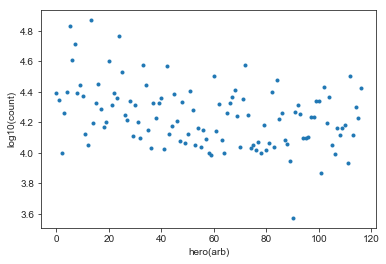

In [43]:
sns.set_style('ticks')
champ_sum = np.concatenate((dota2_train_df['radiant_hero0'],
                            dota2_train_df['radiant_hero1'],
                            dota2_train_df['radiant_hero2'],
                            dota2_train_df['radiant_hero3'],
                            dota2_train_df['radiant_hero4'],
                            dota2_train_df['dire_hero0'],
                            dota2_train_df['dire_hero1'],
                            dota2_train_df['dire_hero2'],
                            dota2_train_df['dire_hero3'],
                            dota2_train_df['dire_hero4']),axis=None)

unique, counts = np.unique(champ_sum, return_counts=True)

plt.plot(np.log10(counts),'.')
plt.xlabel('hero(arb)')
plt.ylabel('log10(count)')
plt.show()

# Get many matches using GetMatchHistoryBySequence
doesn't work great because it doesn't allow for any options. This means you need to filter your results down post-fetch. Because of this you don't gain anything by using this.

In [ ]:
files=glob.glob(os.path.join('Dota_data','mixed_skill','*.csv'))
files.sort(key=os.path.getmtime)
print(files)

In [ ]:
#open all recent data files then use the oldest one to set the initial
#    match_seq_num to use to get matches by GetMatchHistoryBySequenceNum
#TODO: write option to start from a recent match
files=glob.glob(os.path.join('Dota_data','mixed_skill,'*.csv'))
files.sort(key=os.path.getmtime)
start_match = pd.read_csv(files[-1], usecols=[1])['match_id'].iloc[-1]
start_match_seq_num = api.call('IDOTA2Match_'+dota2_id+'.GetMatchDetails',
                        match_id=start_match)['result']['match_seq_num']

num_requested=1e7
match_dict = api.call('IDOTA2Match_'+dota2_id+'.GetMatchHistoryBySequenceNum',
                      start_at_match_seq_num=start_match_seq_num,
                    matches_requested=100)
match_list = match_dict['result']['matches']

consec_err=0
while num_requested>len(match_list):
    time.sleep(1)
    try:
        match_dict=(api.call('IDOTA2Match_'+dota2_id+'.GetMatchHistoryBySequenceNum',
                start_at_match_seq_num=match_list[-1]['match_seq_num'],
                    matches_requested=100))
        match_list.extend(match_dict['result']['matches'])
        consec_err=0
    except requests.exceptions.HTTPError as err:
        print(err)
        if consec_err>2:
            print('triple error')
            break
        else:
            print(len(match_list))
            consec_err+=1
            time.sleep(30)

In [ ]:
consec_err=0
num_requested=2e5
match_list=[match_list[-1]]
while num_requested>len(match_list):
    time.sleep(1)
    try:
        match_dict=(api.call('IDOTA2Match_'+dota2_id+'.GetMatchHistoryBySequenceNum',
                start_at_match_seq_num=match_list[-1]['match_seq_num'],
                    matches_requested=100))
        match_list.extend(match_dict['result']['matches'])
        consec_err=0
    except requests.exceptions.HTTPError as err:
        print(err)
        if consec_err>2:
            print('triple error')
            break
        else:
            print(len(match_list))
            consec_err+=1
            time.sleep(30)
match_list=match_list[1:]

In [ ]:
print(len(match_list))

In [ ]:
radiant_win_column = []; radiant_xp_column = []; dire_xp_column = []; radiant_gold_column = []
dire_gold_column = []; radiant_hero_column = []; dire_hero_column = []; match_id_list = []
match_seq_num_list = []

for match in match_list:
    
    if (match['game_mode']!=1 and match['game_mode']!=2) or match['human_players']!=10:
        continue
    
    match_id_list.append(match['match_id'])
    match_seq_num_list.append(match['match_seq_num'])
    radiant_win_column.append(match['radiant_win'])
    
    dire_xp = 0; radiant_xp = 0    
    dire_gold = 0; radiant_gold = 0
    radiant_hero_row = []; dire_hero_row = []
    #get heroes, xp, and gold for features, target, target
    for player in match['players']:
        #First bit of 8-bit integer player_slot is 1 if the player was on dire
        #so if player was on dire then player_slot > 128
        if player['player_slot']/128<1:
            radiant_hero_row.append(player['hero_id'])
            radiant_xp+=player['xp_per_min']*match['duration']/60
            for item_index in range(5):
                if player['item_'+str(item_index)]!=0:
                    radiant_gold+=int(item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost'])
        else:
            dire_hero_row.append(player['hero_id'])
            dire_xp+=player['xp_per_min']*match['duration']/60
            for item_index in range(5):
                if player['item_'+str(item_index)]!=0:
                    dire_gold+=int(item_df.loc[item_df['id']==player['item_'+str(item_index)]]['cost'])

    dire_xp_column.append(dire_xp)
    radiant_xp_column.append(radiant_xp)
    radiant_gold_column.append(radiant_gold)
    dire_gold_column.append(dire_gold)
    radiant_hero_column.append(radiant_hero_row)
    dire_hero_column.append(dire_hero_row)

In [ ]:
print(len(match_id_list))

In [ ]:
dota2_training_df = pd.DataFrame()

#Add radiant_win column to DataFrame
dota2_training_df['radiant_win'] = 1*np.array(radiant_win_column)

#add xp and gold columns to DataFrame
dota2_training_df['radiant_xp'] = np.array(radiant_xp_column)
dota2_training_df['dire_xp'] = np.array(dire_xp_column)
dota2_training_df['radiant_gold'] = np.array(radiant_gold_column)
dota2_training_df['dire_gold'] = np.array(dire_gold_column)

#add match_id and match_seq_num
dota2_training_df['match_id'] = np.array(match_id_list)
#dota2_training_df['match_seq_num'] = np.array(match_seq_num_list)


#Add dire and radiant heroes to DataFrame under their own columns
for i in range(len(np.array(radiant_hero_column)[0])):
    print(i)
    dota2_training_df['radiant_heroes'+str(i)] = np.array(radiant_hero_column)[:,i]
    dota2_training_df['dire_heroes'+str(i)] = np.array(dire_hero_column)[:,i]

In [ ]:
#purge 0 values from hero_id
dota2_training_df = dota2_training_df[dota2_training_df.radiant_heroes0 != 0]

In [ ]:
#save data to csv file so we have it on disk
dota2_training_df.to_csv(os.path.join('Dota_data',
                                        'mixed_skill',
                                        str(dota2_training_df['match_id'].min())+
                                        '-'+
                                        str(dota2_training_df['match_id'].max())+
                                        '.csv'))